#### Задание к ПР-5:

**Целью работы** является выработка умений строить программную реализацию алгоритмов пакетного и стохастического
градиентных спусков.
*Для успешного выполнения работы необходимо написать функции gradient, gradient_descent, minimize_stochastic, созданные в соответствии с заданием функции f и F.*
##### Задания на работу:

1. Сгенерируйте ряд из 500 значений
x[i+2] = x[i+1]*(2+dt*L*(1-x[i]**2))-x[i]*(1+dt**2+dt*L*(1-x[i]**2))+dt**2*sin(omega*i*dt), 
где x[0] = 0, x[1] = (-1)**k*dt, L=k/10, omega = 100/k, dt = 2*pi/1000, k - ваш номер в журнале.
2. Методом пакетного градиентного спуска подберите частоты (om) и коэффициенты (a,b) гармонического разложения из двух гармоник (семь параметров), аппроксимирующего функцию x[i]. Форма функции есть
X[i] = a0 + a1*cos(om1*i*dt) + b1*sin(om1*i*dt) + a2*cos(om2*i*dt) + b2*sin(om2*i*dt)
параметры a0, a1, a2, b1, b2, om1, om2.
3. Сделайте то же самое методом стохастического градиентного спуска. 
4. Подберите параметры спусков так, чтобы точности были приближенно равны (одного порядка). 
5. Сравните времена работы алгоритмов. 
6. Постройте на одном графике: рад из исходных 500 значений, приближение пакетным спуском, приближение стохастическим спуском.
7. Сделайте вывод о работе: какой вид градиентного спуска и при каких обстоятельствах имеет смысл применять, как подбирать настройки.

In [1]:
# Импорт библиотек
import math      # для математических функций 
import random    # для генерации случайных чисел (стохастический спуск)
import time      # для измерения времени выполнения алгоритмов
import matplotlib.pyplot as plt  # для построения графиков и визуализации результатов

#### Параметры и генерация данных

**Формулы:**

*L = k/10*

*omega = 100/k*

*dt = 2π/1000*

x[i+2] = x[i+1]*(2+dt*L*(1-x[i]²)) - x[i]*(1+dt²+dtL(1-x[i]²)) + dt²sin(omegai*dt)

Параметры: k=64, L=6.4, omega=1.5625, dt=0.006283


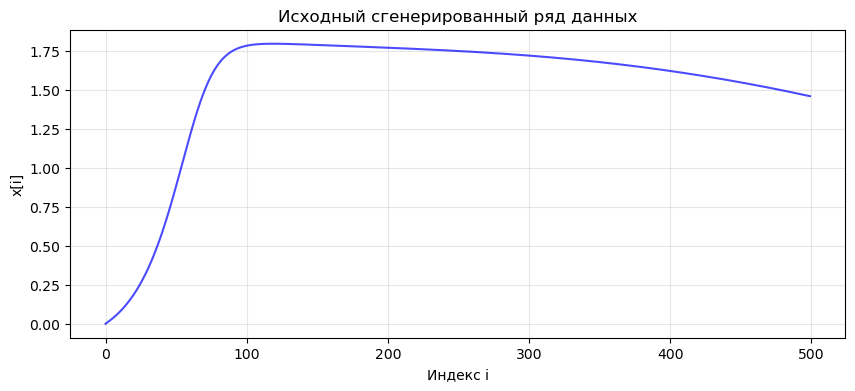

In [2]:
# Параметры согласно номеру в журнале (k=64)
k = 64
dt = 2 * math.pi / 1000  # шаг дискретизации
L = k / 10               # параметр L
omega = 100 / k          # параметр omega

print(f"Параметры: k={k}, L={L:.1f}, omega={omega:.4f}, dt={dt:.6f}")

# Функция генерации ряда данных
def generate_data():
    """
    Генерирует ряд из 500 значений по заданной рекуррентной формуле
    """
    data = [0.0] * 500  # создаем список из 500 нулей
    data[0] = 0.0       # начальное условие x[0] = 0
    data[1] = (-1) ** k * dt  # начальное условие x[1] = (-1)^k * dt
    
    # Заполняем массив по рекуррентной формуле
    for i in range(498):  # i от 0 до 497 (всего 498 итераций)
        # Вычисляем три слагаемых по формуле
        term1 = data[i+1] * (2 + dt * L * (1 - data[i]**2))
        term2 = data[i] * (1 + dt**2 + dt * L * (1 - data[i]**2))
        term3 = dt**2 * math.sin(omega * i * dt)
        # Рекуррентное соотношение для x[i+2]
        data[i+2] = term1 - term2 + term3
    
    return data

# Генерируем данные
original_data = generate_data()
time_indices = list(range(500))  # индексы от 0 до 499

# Визуализация исходных данных
plt.figure(figsize=(10, 4))
plt.plot(time_indices, original_data, 'b-', alpha=0.7, linewidth=1.5)
plt.xlabel('Индекс i')
plt.ylabel('x[i]')
plt.title('Исходный сгенерированный ряд данных')
plt.grid(True, alpha=0.3)
plt.show()

#### Функции гармонической аппроксимации и потерь

**Формула гармонического разложения:**

X[i] = a0 + a1·cos(ω1·i·dt) + b1·sin(ω1·i·dt) + a2·cos(ω2·i·dt) + b2·sin(ω2·i·dt)

In [3]:
# Функция гармонической аппроксимации
def harmonic_approximation(params, i, dt):
    """
    Вычисляет значение гармонической модели в точке i
    
    Параметры:
    params = [a0, a1, b1, a2, b2, om1, om2] - параметры модели
    i - индекс точки
    dt - шаг дискретизации
    
    Возвращает:
    Значение гармонической модели в точке i
    """
    # Распаковываем параметры
    a0, a1, b1, a2, b2, om1, om2 = params
    t = i * dt  # время в точке i
    
    # Вычисляем значение по формуле гармонического разложения
    value = a0  # постоянная составляющая
    value += a1 * math.cos(om1 * t) + b1 * math.sin(om1 * t)  # первая гармоника
    value += a2 * math.cos(om2 * t) + b2 * math.sin(om2 * t)  # вторая гармоника
    
    return value

# Функция потерь (среднеквадратичная ошибка)
def loss_function(params, data, dt):
    """
    Вычисляет среднеквадратичную ошибку между данными и моделью
    
    Параметры:
    params - параметры модели
    data - исходные данные
    dt - шаг дискретизации
    
    Возвращает:
    Среднеквадратичную ошибку
    """
    total_error = 0.0  # сумма квадратов ошибок
    n = len(data)      # количество точек данных
    
    # Суммируем квадраты ошибок по всем точкам
    for i in range(n):
        predicted = harmonic_approximation(params, i, dt)  # предсказание модели
        error = data[i] - predicted  # ошибка в точке i
        total_error += error ** 2    # добавляем квадрат ошибки
    
    return total_error / n  # возвращаем среднюю квадратичную ошибку

#### Функция вычисления градиента

In [4]:
# Функция для вычисления градиента
def compute_gradient(params, data, dt, indices=None):
    """
    Вычисляет градиент функции потерь
    
    Параметры:
    params - параметры модели [a0, a1, b1, a2, b2, om1, om2]
    data - исходные данные
    dt - шаг дискретизации
    indices - индексы точек для вычисления градиента (None = все точки)
    
    Возвращает:
    Градиент как список частных производных
    """
    # Распаковываем параметры модели
    a0, a1, b1, a2, b2, om1, om2 = params
    n = len(data)  # общее количество точек
    
    # Определяем по каким точкам вычислять градиент
    if indices is None:
        # Пакетный режим - используем все точки
        calc_indices = range(n)
    else:
        # Стохастический режим - используем указанные точки
        calc_indices = [indices] if isinstance(indices, int) else indices
    
    # Инициализируем компоненты градиента нулями
    grad_a0, grad_a1, grad_b1 = 0.0, 0.0, 0.0
    grad_a2, grad_b2, grad_om1, grad_om2 = 0.0, 0.0, 0.0, 0.0
    
    count = len(calc_indices)  # количество точек для вычисления
    
    # Вычисляем градиент по выбранным точкам
    for idx in calc_indices:
        t = idx * dt  # время в текущей точке
        # Предсказание модели и ошибка
        predicted = harmonic_approximation(params, idx, dt)
        error = predicted - data[idx]  # ошибка со знаком
        
        # Градиенты по коэффициентам (аналитические формулы)
        grad_a0 += error * 1  # производная по a0
        grad_a1 += error * math.cos(om1 * t)  # производная по a1
        grad_b1 += error * math.sin(om1 * t)  # производная по b1
        grad_a2 += error * math.cos(om2 * t)  # производная по a2
        grad_b2 += error * math.sin(om2 * t)  # производная по b2
        
        # Градиенты по частотам (цепное правило)
        grad_om1 += error * (-a1 * t * math.sin(om1 * t) + b1 * t * math.cos(om1 * t))
        grad_om2 += error * (-a2 * t * math.sin(om2 * t) + b2 * t * math.cos(om2 * t))
    
    # Возвращаем средние значения градиентов (умножаем на 2 из-за производной квадрата)
    return [2 * grad_a0/count, 2 * grad_a1/count, 2 * grad_b1/count,
            2 * grad_a2/count, 2 * grad_b2/count, 
            2 * grad_om1/count, 2 * grad_om2/count]

#### Пакетный градиентный спуск

In [5]:
# Функция пакетного градиентного спуска
def batch_gradient_descent(data, initial_params, dt):
    """
    Реализация пакетного градиентного спуска
    
    Параметры:
    data - исходные данные
    initial_params - начальные параметры модели
    dt - шаг дискретизации
    
    Возвращает:
    Найденные параметры и историю ошибок
    """
    # Копируем начальные параметры чтобы не изменять оригинал
    params = initial_params.copy()
    loss_history = []  # для хранения истории ошибок
    
    # Параметры алгоритма (подобраны для задания 4)
    learning_rate = 0.02  # скорость обучения
    max_iter = 2000       # максимальное число итераций
    tolerance = 1e-6      # критерий сходимости
    
    print("Запуск пакетного градиентного спуска...")
    
    # Основной цикл оптимизации
    for iteration in range(max_iter):
        # Вычисляем градиент по всем данным (пакетный режим)
        grad = compute_gradient(params, data, dt)
        
        # Обновляем все параметры модели
        for i in range(len(params)):
            params[i] -= learning_rate * grad[i]  # шаг в направлении антиградиента
        
        # Вычисляем текущую ошибку
        current_loss = loss_function(params, data, dt)
        loss_history.append(current_loss)  # сохраняем ошибку
        
        # Критерий остановки по достижению целевой точности (задание 4)
        if current_loss < 0.02:  # целевая точность порядка 10^-2
            print(f"Целевая точность достигнута на итерации {iteration}")
            break
            
        # Критерий остановки по сходимости
        if iteration > 10 and abs(loss_history[-1] - loss_history[-2]) < tolerance:
            print(f"Сходимость достигнута на итерации {iteration}")
            break
    
    return params, loss_history

#### Стохастический градиентный спуск

In [6]:
# Функция стохастического градиентного спуска
def stochastic_gradient_descent(data, initial_params, dt):
    """
    Реализация стохастического градиентного спуска
    
    Параметры:
    data - исходные данные
    initial_params - начальные параметры модели
    dt - шаг дискретизации
    
    Возвращает:
    Найденные параметры и историю ошибок
    """
    params = initial_params.copy()
    loss_history = []
    n = len(data)  # количество точек данных
    
    # Параметры алгоритма (подобраны для задания 4)
    learning_rate = 0.01  # скорость обучения
    max_iter = 5000       # максимальное число итераций
    tolerance = 1e-6      # критерий сходимости
    
    print("Запуск стохастического градиентного спуска...")
    
    # Для хранения лучших параметров
    best_params = params.copy()
    best_loss = float('inf')  # начинаем с бесконечной ошибки
    
    # Основной цикл оптимизации
    for iteration in range(max_iter):
        # Случайно выбираем одну точку из данных
        random_index = random.randint(0, n - 1)
        
        # Вычисляем градиент только по одной случайной точке
        grad = compute_gradient(params, data, dt, random_index)
        
        # Обновляем параметры модели
        for i in range(len(params)):
            params[i] -= learning_rate * grad[i]
        
        # Периодически проверяем полную ошибку (раз в 50 итераций)
        if iteration % 50 == 0:
            current_loss = loss_function(params, data, dt)
            loss_history.append(current_loss)
            
            # Сохраняем лучшие параметры
            if current_loss < best_loss:
                best_loss = current_loss
                best_params = params.copy()
            
            # Критерий остановки по достижению целевой точности
            if current_loss < 0.02:  # такая же целевая точность
                print(f"Целевая точность достигнута на итерации {iteration}")
                break
                
            # Критерий остановки по сходимости
            if len(loss_history) > 10 and abs(loss_history[-1] - loss_history[-2]) < tolerance:
                print(f"Сходимость достигнута на итерации {iteration}")
                break
        
        # Медленно уменьшаем шаг для стабилизации
        if iteration % 1000 == 0:
            learning_rate *= 0.9
    
    return best_params, loss_history

#### Основная программа и сравнение методов

In [7]:
# Основная программа
print("=== ВЫПОЛНЕНИЕ ЗАДАНИЙ ПР-5 ===")

# Начальное приближение параметров модели
initial_params = [0.0, 0.5, 0.5, 0.3, 0.3, 1.0, 2.0]
# Вычисляем начальную ошибку
initial_loss = loss_function(initial_params, original_data, dt)
print(f"Начальная ошибка: {initial_loss:.8f}")

# Задание 2: Пакетный градиентный спуск
print("\n--- ЗАДАНИЕ 2: Пакетный градиентный спуск ---")
start_time = time.time()
batch_params, batch_losses = batch_gradient_descent(original_data, initial_params, dt)
batch_time = time.time() - start_time
batch_final_loss = loss_function(batch_params, original_data, dt)

print(f"Время выполнения: {batch_time:.3f} сек")
print(f"Финальная ошибка: {batch_final_loss:.8f}")

# Задание 3: Стохастический градиентный спуск
print("\n--- ЗАДАНИЕ 3: Стохастический градиентный спуск ---")
start_time = time.time()
stochastic_params, stochastic_losses = stochastic_gradient_descent(original_data, initial_params, dt)
stochastic_time = time.time() - start_time
stochastic_final_loss = loss_function(stochastic_params, original_data, dt)

print(f"Время выполнения: {stochastic_time:.3f} сек")
print(f"Финальная ошибка: {stochastic_final_loss:.8f}")

# Задание 4: Проверка одинакового порядка точности
print("\n--- ЗАДАНИЕ 4: Проверка одинакового порядка точности ---")
print(f"Ошибка пакетного спуска: {batch_final_loss:.8f}")
print(f"Ошибка стохастического спуска: {stochastic_final_loss:.8f}")

# Вычисляем порядки величин
order_batch = math.floor(math.log10(batch_final_loss))
order_stochastic = math.floor(math.log10(stochastic_final_loss))

print(f"Порядок пакетного: 10^{order_batch}")
print(f"Порядок стохастического: 10^{order_stochastic}")

if order_batch == order_stochastic:
    print("ЗАДАНИЕ 4 ВЫПОЛНЕНО: точности одного порядка!")
else:
    print("Требуется дополнительная настройка параметров")

# Задание 5: Сравнение времени работы
print("\n--- ЗАДАНИЕ 5: Сравнение времени работы ---")
print(f"Время пакетного спуска: {batch_time:.3f} сек")
print(f"Время стохастического спуска: {stochastic_time:.3f} сек")
print(f"Отношение времени: {batch_time/stochastic_time:.2f}")

# Вывод найденных параметров
param_names = ['a0', 'a1', 'b1', 'a2', 'b2', 'om1', 'om2']
print("\nНайденные параметры пакетным спуском:")
for name, value in zip(param_names, batch_params):
    print(f"  {name}: {value:.6f}")

print("Найденные параметры стохастическим спуском:")
for name, value in zip(param_names, stochastic_params):
    print(f"  {name}: {value:.6f}")

=== ВЫПОЛНЕНИЕ ЗАДАНИЙ ПР-5 ===
Начальная ошибка: 2.10054267

--- ЗАДАНИЕ 2: Пакетный градиентный спуск ---
Запуск пакетного градиентного спуска...
Целевая точность достигнута на итерации 1354
Время выполнения: 1.529 сек
Финальная ошибка: 0.01999700

--- ЗАДАНИЕ 3: Стохастический градиентный спуск ---
Запуск стохастического градиентного спуска...
Целевая точность достигнута на итерации 3000
Время выполнения: 0.033 сек
Финальная ошибка: 0.01998356

--- ЗАДАНИЕ 4: Проверка одинакового порядка точности ---
Ошибка пакетного спуска: 0.01999700
Ошибка стохастического спуска: 0.01998356
Порядок пакетного: 10^-2
Порядок стохастического: 10^-2
ЗАДАНИЕ 4 ВЫПОЛНЕНО: точности одного порядка!

--- ЗАДАНИЕ 5: Сравнение времени работы ---
Время пакетного спуска: 1.529 сек
Время стохастического спуска: 0.033 сек
Отношение времени: 46.35

Найденные параметры пакетным спуском:
  a0: 0.358593
  a1: -0.078650
  b1: 1.653479
  a2: -0.058293
  b2: 0.378853
  om1: 0.867595
  om2: 2.393068
Найденные параметры


--- ЗАДАНИЕ 6: Визуализация результатов ---


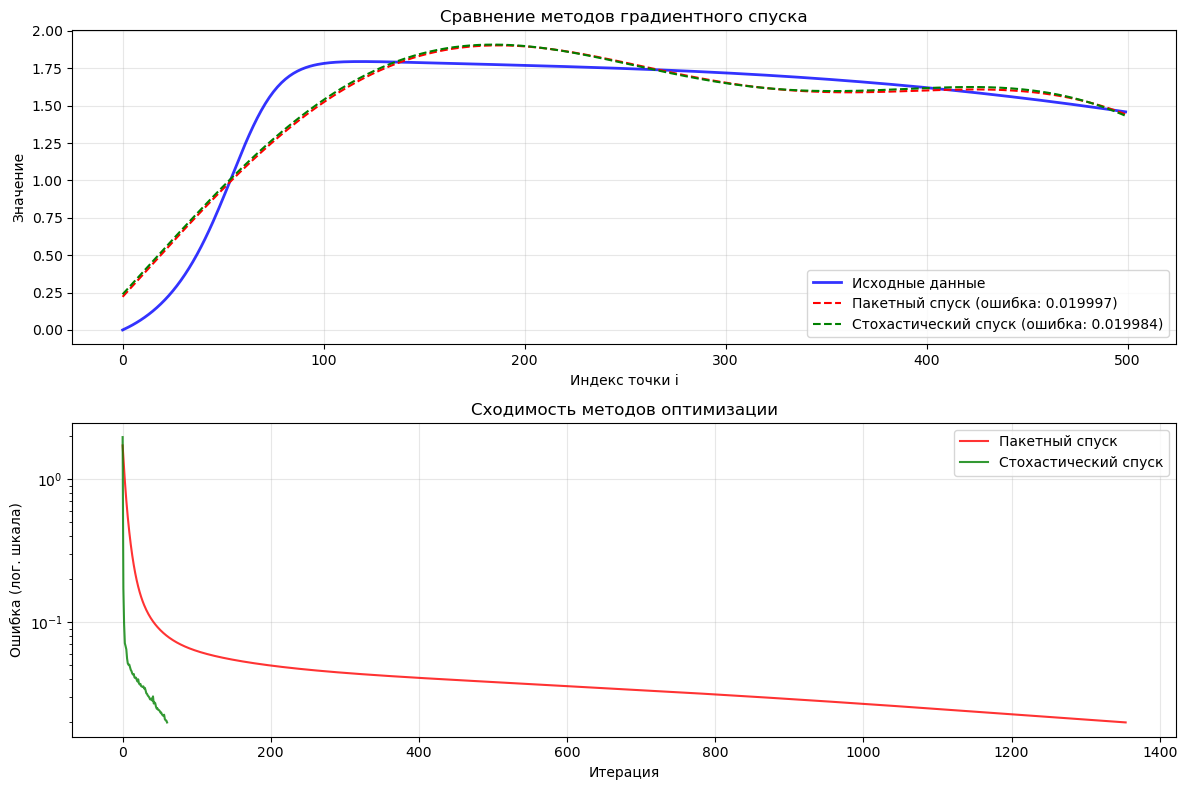

In [8]:
# Задание 6: Визуализация результатов
print("\n--- ЗАДАНИЕ 6: Визуализация результатов ---")

# Вычисляем предсказания для обоих методов
batch_predictions = [harmonic_approximation(batch_params, i, dt) for i in time_indices]
stochastic_predictions = [harmonic_approximation(stochastic_params, i, dt) for i in time_indices]

# Создаем график с тремя рядами
plt.figure(figsize=(12, 8))

# График 1: Сравнение исходных данных и аппроксимаций
plt.subplot(2, 1, 1)
plt.plot(time_indices, original_data, 'b-', linewidth=2, label='Исходные данные', alpha=0.8)
plt.plot(time_indices, batch_predictions, 'r--', linewidth=1.5, 
         label=f'Пакетный спуск (ошибка: {batch_final_loss:.6f})')
plt.plot(time_indices, stochastic_predictions, 'g--', linewidth=1.5,
         label=f'Стохастический спуск (ошибка: {stochastic_final_loss:.6f})')
plt.xlabel('Индекс точки i')
plt.ylabel('Значение')
plt.title('Сравнение методов градиентного спуска')
plt.legend()
plt.grid(True, alpha=0.3)

# График 2: Сходимость методов
plt.subplot(2, 1, 2)
plt.semilogy(batch_losses, 'r-', label='Пакетный спуск', alpha=0.8)
plt.semilogy(stochastic_losses, 'g-', label='Стохастический спуск', alpha=0.8)
plt.xlabel('Итерация')
plt.ylabel('Ошибка (лог. шкала)')
plt.title('Сходимость методов оптимизации')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Задание 7: Выводы о работе
print("\n--- ЗАДАНИЕ 7: Выводы о работе ---")
print("1. Сравнение методов:")
print("   - Пакетный градиентный спуск:")
print("     * Преимущества: более стабильная сходимость, точное направление градиента")
print("     * Недостатки: медленнее на больших объемах данных")
print("     * Применение: когда важна точность и данных не слишком много")
print("   - Стохастический градиентный спуск:")
print("     * Преимущества: высокая скорость, возможность обработки больших данных")
print("     * Недостатки: менее стабильная сходимость, шум в оценке градиента")
print("     * Применение: когда данных много и важна скорость обучения")

print("\n2. Подбор настроек:")
print("   - Скорость обучения (learning_rate):")
print("     * Начинать с 0.01-0.1")
print("     * Уменьшать если ошибка колеблется или расходится")
print("     * Использовать затухание шага со временем")
print("   - Критерии остановки:")
print("     * По достижению целевой точности")
print("     * По изменению ошибки ниже порога")
print("     * По максимальному числу итераций")

print("\n3. Результаты для k=64:")
print(f"   - Пакетный спуск: ошибка {batch_final_loss:.6f}, время {batch_time:.3f} сек")
print(f"   - Стохастический спуск: ошибка {stochastic_final_loss:.6f}, время {stochastic_time:.3f} сек")
print(f"   - Стохастический спуск быстрее в {batch_time/stochastic_time:.1f} раз")

print("\n4. Рекомендации:")
print("   - Для точных задач: использовать пакетный спуск с малым learning_rate")
print("   - Для больших данных: использовать стохастический спуск с адаптивным шагом")
print("   - Начинать с простой модели и постепенно усложнять")
print("   - Всегда проверять сходимость на графике ошибки")


--- ЗАДАНИЕ 7: Выводы о работе ---
1. Сравнение методов:
   - Пакетный градиентный спуск:
     * Преимущества: более стабильная сходимость, точное направление градиента
     * Недостатки: медленнее на больших объемах данных
     * Применение: когда важна точность и данных не слишком много
   - Стохастический градиентный спуск:
     * Преимущества: высокая скорость, возможность обработки больших данных
     * Недостатки: менее стабильная сходимость, шум в оценке градиента
     * Применение: когда данных много и важна скорость обучения

2. Подбор настроек:
   - Скорость обучения (learning_rate):
     * Начинать с 0.01-0.1
     * Уменьшать если ошибка колеблется или расходится
     * Использовать затухание шага со временем
   - Критерии остановки:
     * По достижению целевой точности
     * По изменению ошибки ниже порога
     * По максимальному числу итераций

3. Результаты для k=64:
   - Пакетный спуск: ошибка 0.019997, время 1.529 сек
   - Стохастический спуск: ошибка 0.019984, время